In [27]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf




fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 36 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/dejavu: caching, new cache contents: 22 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/opt/ml/.local/share/fonts: skipping, no such directory
/opt/ml/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/opt/ml/.cache/fontconfig: not cleaning non-existent cache directory
/opt/ml/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [1]:
import dataclasses
import json
import random
from collections import defaultdict, Counter
from copy import deepcopy
from dataclasses import dataclass
from typing import List, Optional, Union
from pprint import pprint
import numpy as np
import torch
from torch.utils.data import Dataset
from tqdm import tqdm
from konlpy.tag import Mecab
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline 
import matplotlib
from matplotlib import rc

# # 아래 주석부분은 한글폰트를 사용하기 위한 코드로, 최초 1회만 실행하면 됩니다.
# %config InlineBackend.figure_format = 'retina'
# !apt -qq -y install fonts-nanum

# 폰트 설정
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
rc('font', family='NanumBarunGothic')


slot_meta_path = "../input/data/train_dataset/slot_meta.json"
train_data_path = f"../input/data/train_dataset/train_dials.json"

slot_meta = json.load(open(slot_meta_path))
train_data = json.load(open(train_data_path))


## 1) WoS의 Domain은 몇개이며, 어떤 Domain으로 이루어져있는지 확인해봅니다



In [43]:

## domain들을 flatten하여 나열한 다음, 빈도수를 카운팅해주었음
domains_list = []
for dialogue in train_data:
  domains_list.extend(dialogue['domains'])

idx = [item[0] for item in Counter(domains_list).items()]
value = [item[1] for item in Counter(domains_list).items()]


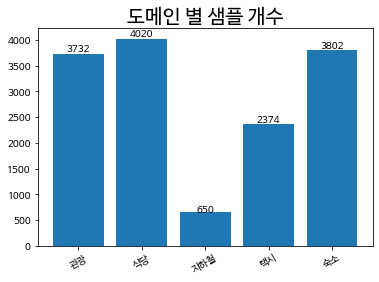

In [51]:
from matplotlib import font_manager,rc

def plot_bar_chart(idx,value,xtick_rotation,title):
    fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
    # fontprop = font_manager.FontProperties(fname=fontpath, size=18)
    font_name = font_manager.FontProperties(fname=fontpath).get_name()
    rc('font',family=font_name)
    # font_manager._rebuild()
    plt.rcParams['axes.unicode_minus'] = False

    plt.bar(range(len(value)), value)
    plt.title(title, fontsize=20)
    ax = plt.subplot()
    ax.set_xticks(range(len(idx)))
    ax.set_xticklabels(idx, rotation=xtick_rotation)  # 축의 이름을 30도만큼 회전시켜서 적음

    # ax.annotate(s, xy, *args, **kwargs) 는 그래프 안에 특정 위치에 문자열을 찍어준다.
    # s 인자에 문자열을 넣어주면된다.
    # xy 에는 튜플로 문자열이 들어갈 (x, y) 위치를 넣어주면 된다.
    # 위 코드에서는 (left+width/2, height*1.01) 를 주었는데, 잘 해석해보면,
    # x는 현재 막대그래프의 가운데 위치
    # y는 현재 막대그래프의 높이 위치임을 알 수 있다.
    # y*1.01 은 막대그래프의 높이보다 조금 더 높게(0.01 더 높게) 일종의 마진을 준 것이다. 바꿔도 상관없다.
    # ha 는 짐작할 수 있듯이, horizontal align 이다. 이를 center 로 둬야, 중심축이 가운데로 온다.

    # value 숫자 annotation
    for v, p in zip(value,ax.patches):
        left, bottom, width, height = p.get_bbox().bounds
        ax.annotate(v, (left+width/2, height*1.01), ha='center')
    plt.show()

plot_bar_chart(idx,value,xtick_rotation=30,title='도메인 별 샘플 개수')

## 2) WoS의 Slot은 몇개이며, Domain별로 어떤 Slot으로 이루어져있는지 확인해봅니다.



In [26]:
# # Domain별로 어떤 Slot으로 이루어져있는지 (중복제거 안함)
# slot_per_domain_dict = defaultdict(list)
# value_per_domain_and_slot_dict = defaultdict(list)

# for data in train_data:
#   for dg in data['dialogue']:
#     if dg['role']=='user':
#       for state in dg['state']:
#         domain, slot, value = state.split('-')
#         slot_per_domain_dict[domain].append(slot)
#         value_per_domain_and_slot_dict[domain+'_'+slot].append(value)
# slot_per_domain_dict
# value_per_domain_and_slot_dict

In [50]:
# slot별 갯수 Counting
count_slot = Counter()
for data in train_data:
  # 중복 허용하지 않는 빈 set 객체
  slot_set = set()
  for dg in data['dialogue']:
    if dg['role']=='user':
      slot_set.update([state.split('-')[1] for state in dg['state']])
  count_slot += Counter(slot_set)
# 도메인 상관없이 슬롯의 종류 갯수
len(count_slot)
# 구해보긴 했지만 이게 무슨 의미가 있을까..?
# 그냥 도메인-슬롯 별 종류를 카운팅하자


26

In [37]:
# 상위 카테고리인 domain 종류들은 5개가 있다.
domain_categories = set(domain_slot_name.split('-')[0] for domain_slot_name in slot_meta)
domain_categories

{'관광', '숙소', '식당', '지하철', '택시'}

In [49]:
# domain - slot별 갯수 Counting
count_domain_slot = Counter()
for data in train_data:
  # 중복 허용하지 않는 빈 set 객체
  slot_set = set()
  for dg in data['dialogue']:
    if dg['role']=='user':
      slot_set.update([state.split('-')[0] + '-' + state.split('-')[1] for state in dg['state']])
  count_domain_slot += Counter(slot_set)
# 도메인-슬롯 순서쌍의 종류는 몇개인가?
len(count_domain_slot)

45

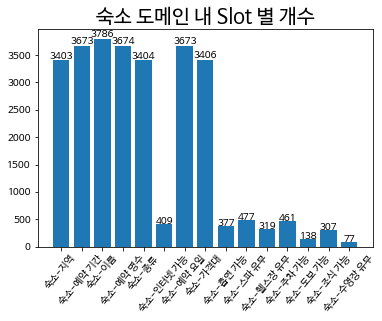

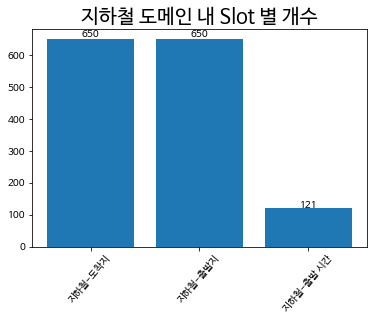

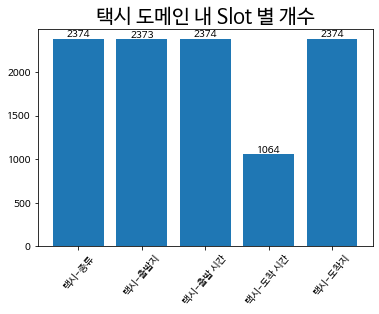

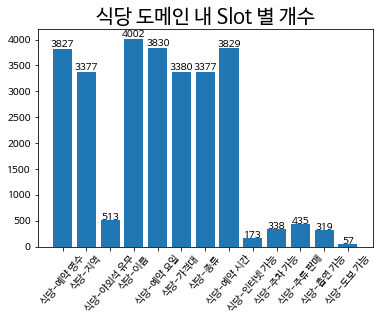

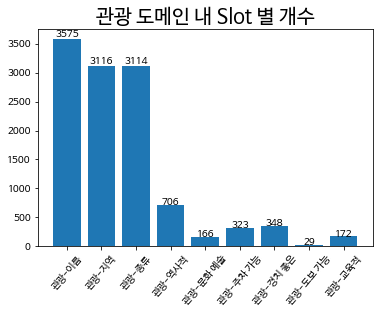

In [52]:
# Domain Category별로 Bar Chart
for category in domain_categories:
  key_current_category = []
  value_current_category = []
  for k,v in count_domain_slot.items():
    if k.startswith(category):
      key_current_category.append(k)
      value_current_category.append(v)
  plot_bar_chart(key_current_category,value_current_category,xtick_rotation=50,title=f'{category} 도메인 내 Slot 별 개수')

## 3) WoS의 Value은 몇개이며, Slot당 Value가 어떻게 이루어져있는지 확인해봅니다.



In [66]:
# 도메인-슬롯-value 별로 각각 갯수 카운팅 객체
count_state = Counter()
for data in train_data:
  # 중복 허용하지 않는 빈 set 객체
  state_set = set()
  for dg in data['dialogue']:
    if dg['role']=='user':
      state_set.update(dg['state'])
  count_state += Counter(state_set)
count_state

Counter({'식당-지역-서울 중앙': 780,
         '식당-가격대-저렴': 541,
         '식당-종류-한식당': 915,
         '식당-이름-외계인의맛집': 181,
         '식당-예약 요일-토요일': 582,
         '식당-가격대-비싼': 636,
         '식당-예약 시간-18:00': 62,
         '관광-지역-서울 중앙': 753,
         '관광-이름-문화역서울 284': 23,
         '식당-야외석 유무-yes': 513,
         '관광-종류-박물관': 338,
         '식당-예약 명수-1': 696,
         '관광-지역-서울 서쪽': 317,
         '관광-종류-쇼핑': 224,
         '관광-이름-노량진 수산물 도매시장': 20,
         '식당-지역-dontcare': 802,
         '식당-가격대-적당': 841,
         '식당-이름-어차피자': 127,
         '관광-지역-서울 북쪽': 695,
         '관광-종류-기타': 154,
         '식당-예약 명수-4': 557,
         '지하철-출발지-혜화역': 27,
         '식당-예약 요일-금요일': 586,
         '관광-이름-서울 대학로': 20,
         '식당-종류-양식당': 542,
         '식당-예약 시간-03:30': 50,
         '지하철-도착지-동대문역': 22,
         '식당-예약 명수-3': 577,
         '식당-가격대-dontcare': 1481,
         '관광-지역-dontcare': 836,
         '식당-예약 시간-12:30': 50,
         '식당-예약 요일-수요일': 546,
         '관광-종류-공원': 332,
         '식당-이름-내맘속의나폴리': 177,
      

In [60]:
print(domain_categories)
# 상위 카테고리인 domain-slot 순서쌍의 종류들은 45개가 있다.
domain_slot_categories = set(domain_slot_name.split('-')[0]+'-'+domain_slot_name.split('-')[1] for domain_slot_name in slot_meta)
print(len(domain_slot_categories))  # 45

# 도메인 별로 어떤 슬롯들을 가지고 있는지 미리 구분해놓자.
dict_slot_per_domain = defaultdict(list)
for domain in domain_categories:
  for d_s_cat in domain_slot_categories:
    if d_s_cat.startswith(domain):
      dict_slot_per_domain[domain].append(d_s_cat)

# dict_slot_per_domain

{'숙소', '지하철', '택시', '식당', '관광'}
45


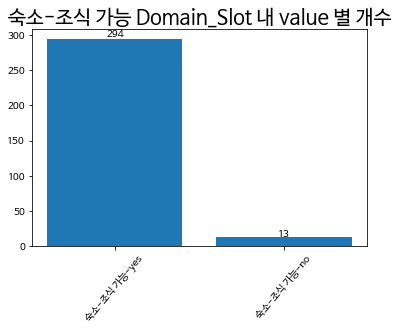

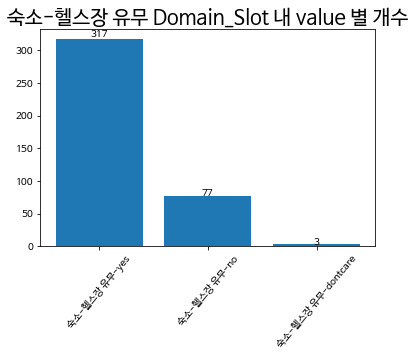

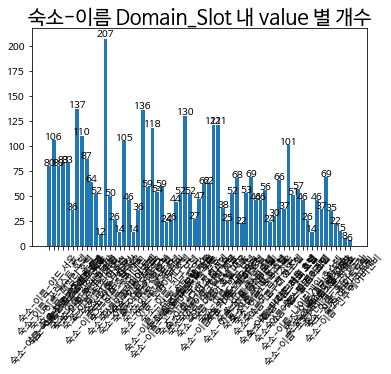

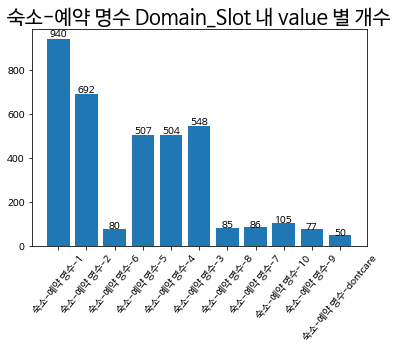

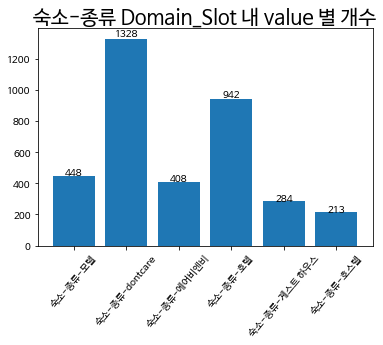

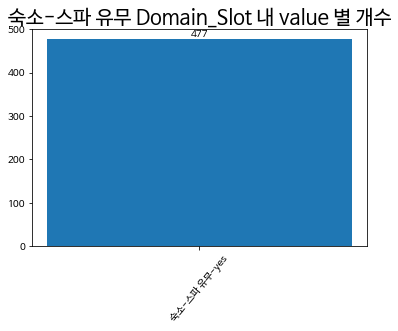

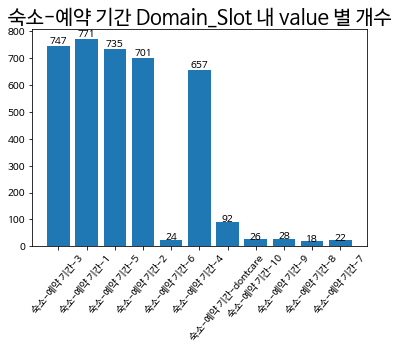

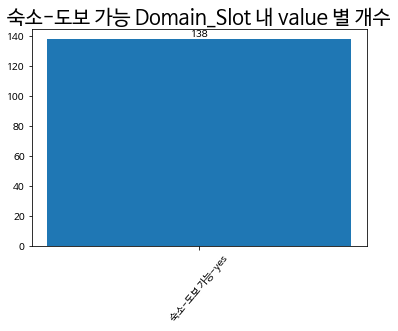

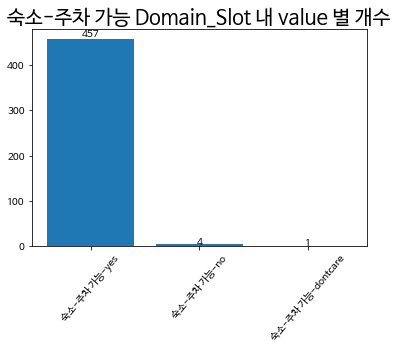

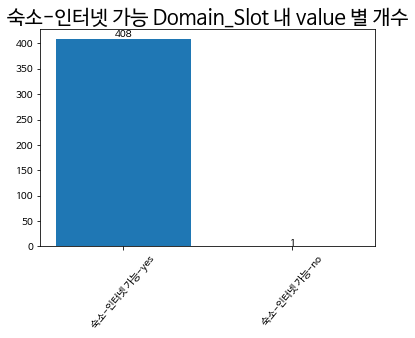

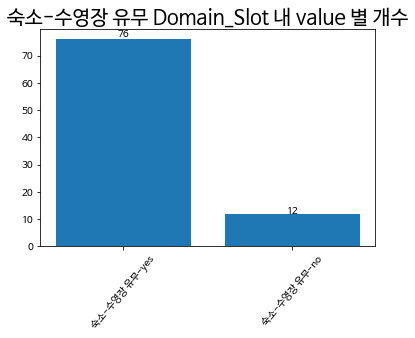

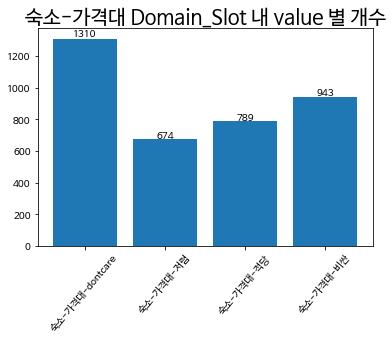

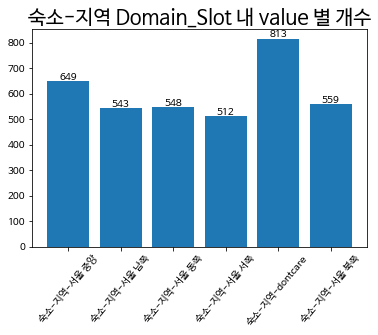

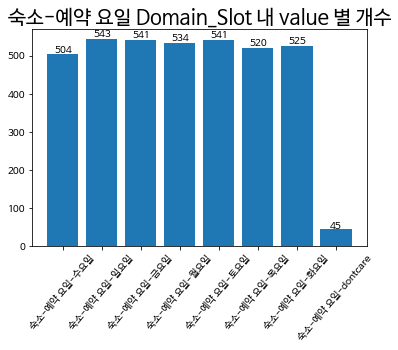

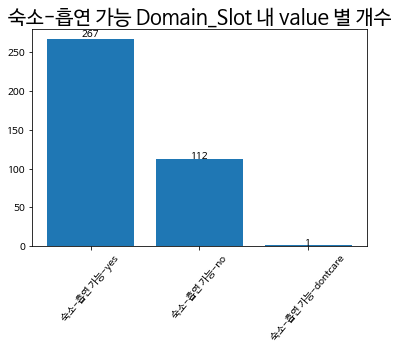

In [80]:
# 도메인 종류 : {'숙소', '지하철', '택시', '식당', '관광'}
# 숙소 도메인에 대해서 bar chart plot
for domain_slot in dict_slot_per_domain['숙소']:
  key_current_domain_slot = []
  value_current_domain_slot = []
  for domain_slot_value, count in count_state.items():
    if domain_slot_value.startswith(domain_slot):
      key_current_domain_slot.append(domain_slot_value)
      value_current_domain_slot.append(count)
  plot_bar_chart(key_current_domain_slot,value_current_domain_slot,xtick_rotation=50,title=f'{domain_slot} Domain_Slot 내 value 별 개수')

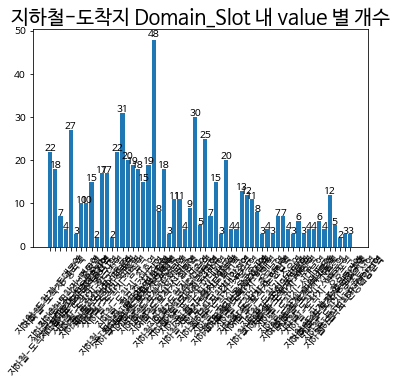

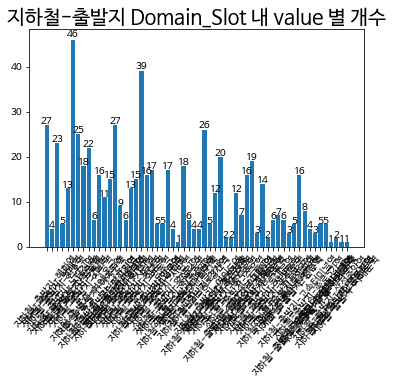

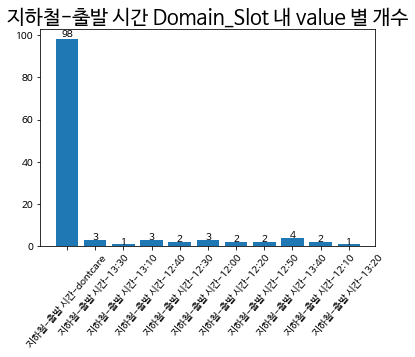

In [79]:
# 도메인 종류 : {'숙소', '지하철', '택시', '식당', '관광'}
# 지하철 도메인에 대해서 bar chart plot
for domain_slot in dict_slot_per_domain['지하철']:
  key_current_domain_slot = []
  value_current_domain_slot = []
  for domain_slot_value, count in count_state.items():
    if domain_slot_value.startswith(domain_slot):
      key_current_domain_slot.append(domain_slot_value)
      value_current_domain_slot.append(count)
  plot_bar_chart(key_current_domain_slot,value_current_domain_slot,xtick_rotation=50,title=f'{domain_slot} Domain_Slot 내 value 별 개수')

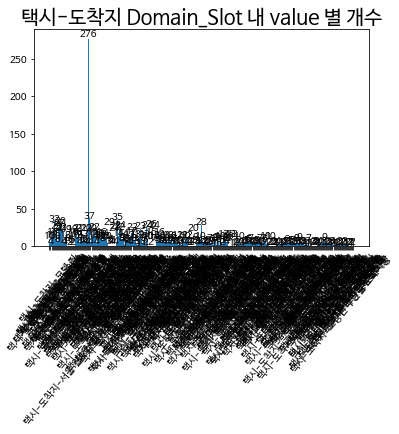

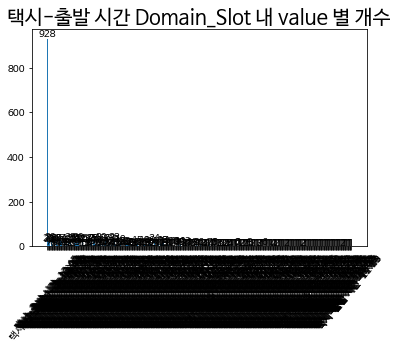

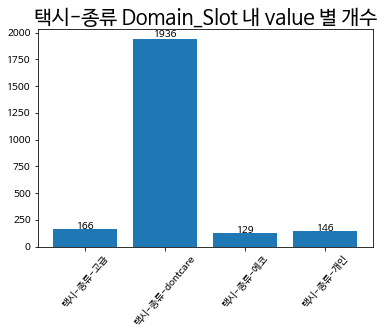

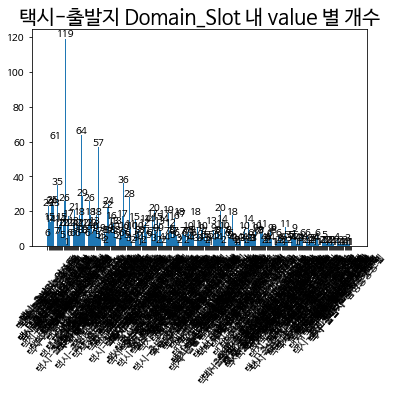

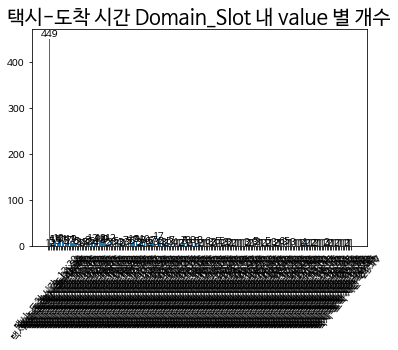

In [78]:
# 도메인 종류 : {'숙소', '지하철', '택시', '식당', '관광'}
# 택시 도메인에 대해서 bar chart plot
for domain_slot in dict_slot_per_domain['택시']:
  key_current_domain_slot = []
  value_current_domain_slot = []
  for domain_slot_value, count in count_state.items():
    if domain_slot_value.startswith(domain_slot):
      key_current_domain_slot.append(domain_slot_value)
      value_current_domain_slot.append(count)
  plot_bar_chart(key_current_domain_slot,value_current_domain_slot,xtick_rotation=50,title=f'{domain_slot} Domain_Slot 내 value 별 개수')

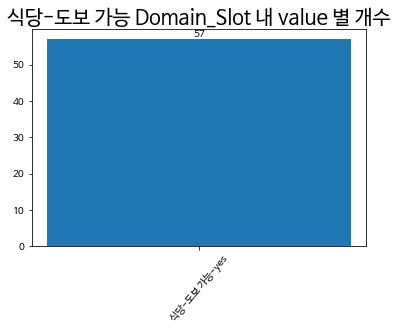

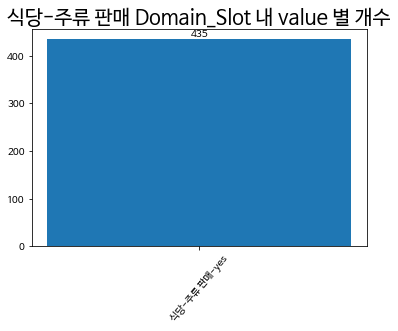

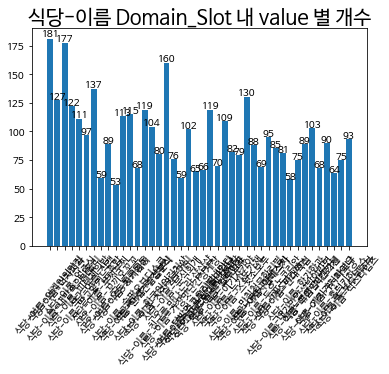

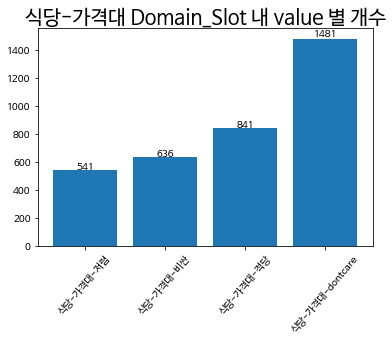

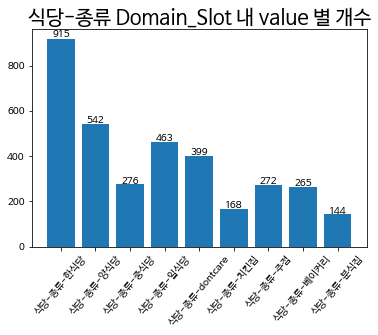

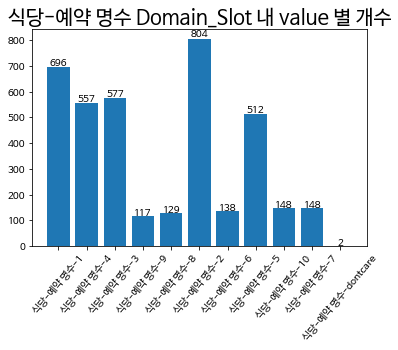

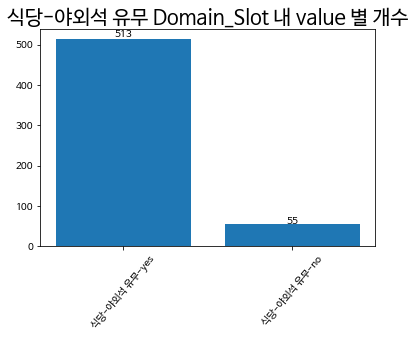

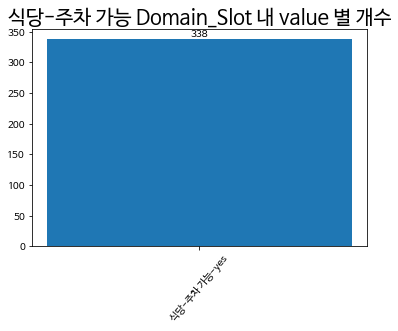

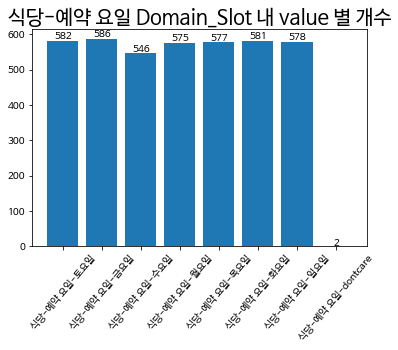

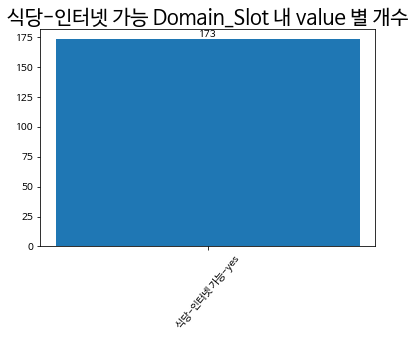

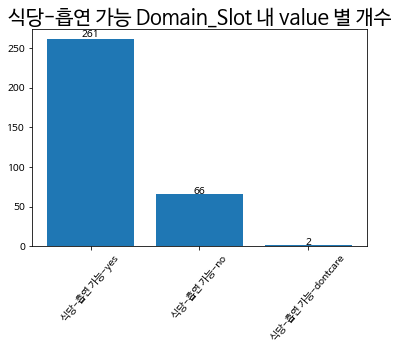

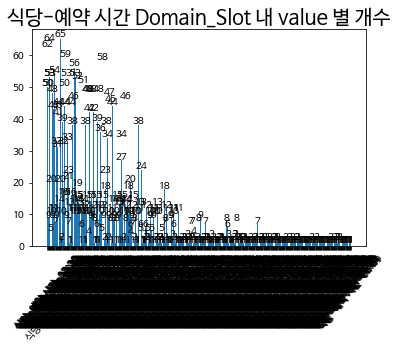

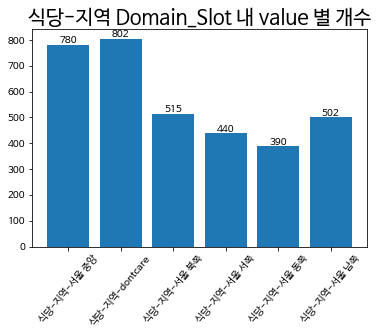

In [77]:
# 도메인 종류 : {'숙소', '지하철', '택시', '식당', '관광'}
# 식당 도메인에 대해서 bar chart plot
for domain_slot in dict_slot_per_domain['식당']:
  key_current_domain_slot = []
  value_current_domain_slot = []
  for domain_slot_value, count in count_state.items():
    if domain_slot_value.startswith(domain_slot):
      key_current_domain_slot.append(domain_slot_value)
      value_current_domain_slot.append(count)
  plot_bar_chart(key_current_domain_slot,value_current_domain_slot,xtick_rotation=50,title=f'{domain_slot} Domain_Slot 내 value 별 개수')

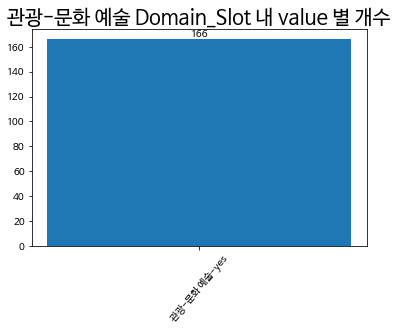

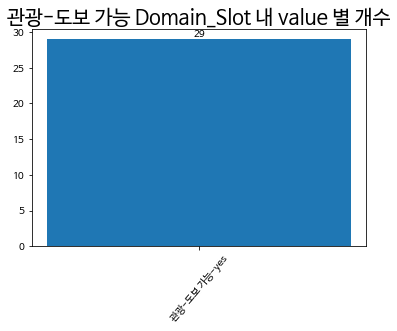

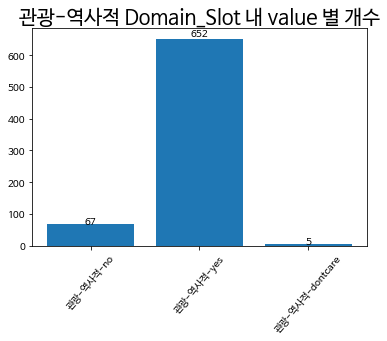

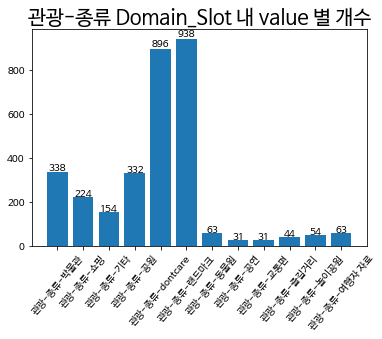

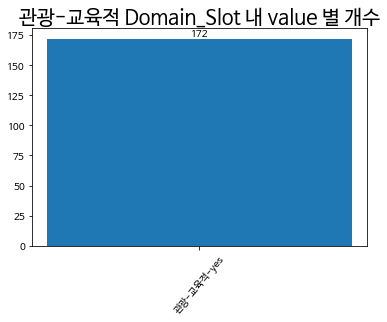

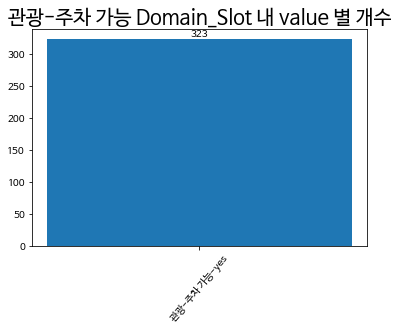

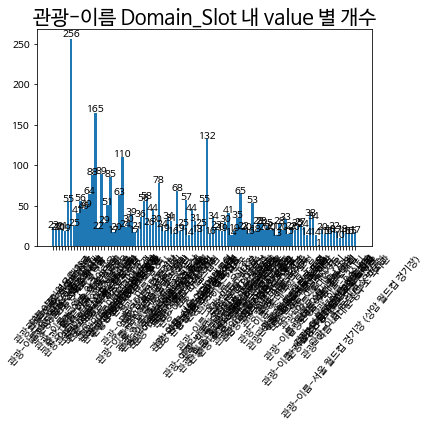

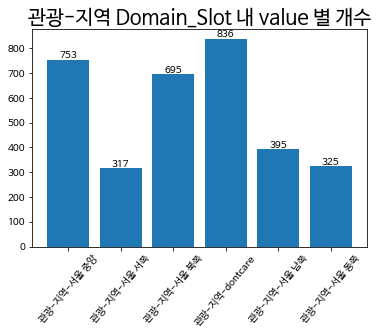

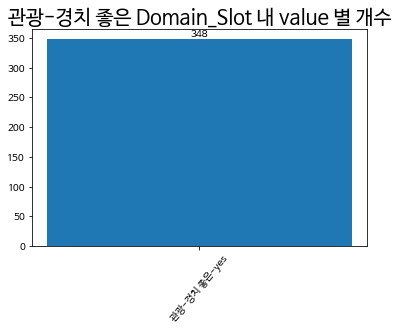

In [81]:
# 도메인 종류 : {'숙소', '지하철', '택시', '식당', '관광'}
# 관광 도메인에 대해서 bar chart plot
for domain_slot in dict_slot_per_domain['관광']:
  key_current_domain_slot = []
  value_current_domain_slot = []
  for domain_slot_value, count in count_state.items():
    if domain_slot_value.startswith(domain_slot):
      key_current_domain_slot.append(domain_slot_value)
      value_current_domain_slot.append(count)
  plot_bar_chart(key_current_domain_slot,value_current_domain_slot,xtick_rotation=50,title=f'{domain_slot} Domain_Slot 내 value 별 개수')

## 4) Domain별로 자주 사용되는 Bigram과 Trigram은 어떤것인지 확인해봅니다.

- 위에서 그린 bar chart들이 bigram과 trigram이 고려된 것